In [ ]:
!pip install gensim

import gensim.downloader as api

# تحميل النموذج
model = api.load("word2vec-google-news-300")

# استخدام النموذج (مثال)
print(model.most_similar("football"))


[==================================================] 100.0% 1662.8/1662.8MB downloaded
[('soccer', 0.731354832649231), ('fooball', 0.7139959335327148), ('Football', 0.7124834060668945), ('basketball', 0.668246865272522), ('footbal', 0.6649289727210999), ('athletics', 0.6265192627906799), ('gridiron', 0.6191604733467102), ('baseball', 0.6162001490592957), ('footballl', 0.6069177985191345), ('sports', 0.5927178859710693)]


In [56]:
from google.colab import files
uploaded = files.upload()


Saving sample_submission.csv to sample_submission (2).csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [31]:
import numpy as np
import pandas as pd
df= pd.read_csv('train.csv')
df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [57]:
##1
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")


In [58]:


def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r"<.*?>", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = text.lower()
    return text

df_train['clean_text'] = df_train['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

df_train['filtered_text'] = df_train['clean_text'].apply(remove_stopwords)
df_test['filtered_text'] = df_test['clean_text'].apply(remove_stopwords)

stemmer = PorterStemmer()

def stem_text(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df_train['stemmed_text'] = df_train['filtered_text'].apply(stem_text)
df_test['stemmed_text'] = df_test['filtered_text'].apply(stem_text)

vectorizer = CountVectorizer(max_features=5000)
X_train_tokens = vectorizer.fit_transform(df_train['stemmed_text'])
X_test_tokens = vectorizer.transform(df_test['stemmed_text'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
##3
def extract_additional_features(df):
    df['tweet_length'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    return df[['tweet_length', 'word_count']]

train_additional_features = extract_additional_features(df_train)
test_additional_features = extract_additional_features(df_test)

train_additional_features_sparse = csr_matrix(train_additional_features.values)
test_additional_features_sparse = csr_matrix(test_additional_features.values)

X_train_final = hstack([X_train_tokens, train_additional_features_sparse])
X_test_final = hstack([X_test_tokens, test_additional_features_sparse])

scaler = StandardScaler(with_mean=False)
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

y_train = df_train["target"].values

X_train, X_val, y_train, y_val = train_test_split(X_train_final, y_train, test_size=0.2, random_state=42)


In [60]:
##4
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_val)
print(" Naive Bayes: ", accuracy_score(y_val, nb_pred))
print(classification_report(y_val, nb_pred))


 Naive Bayes:  0.7327642810242941
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       874
           1       0.69      0.69      0.69       649

    accuracy                           0.73      1523
   macro avg       0.73      0.73      0.73      1523
weighted avg       0.73      0.73      0.73      1523



In [61]:
##4
log_reg_model = LogisticRegression(max_iter=2000)
param_grid_lr = {'C': [0.1, 1, 10]}
grid_lr = GridSearchCV(log_reg_model, param_grid_lr, cv=5)
grid_lr.fit(X_train, y_train)
lr_best_model = grid_lr.best_estimator_
lr_pred = lr_best_model.predict(X_val)
print("Logistic Regression: ", accuracy_score(y_val, lr_pred))
print(classification_report(y_val, lr_pred))



Logistic Regression:  0.7235718975705844
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       874
           1       0.67      0.69      0.68       649

    accuracy                           0.72      1523
   macro avg       0.72      0.72      0.72      1523
weighted avg       0.72      0.72      0.72      1523



In [62]:
###4
svm_model = SVC()
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
svm_best_model = grid_svm.best_estimator_
svm_pred = svm_best_model.predict(X_val)
print("Support Vector Machines: ", accuracy_score(y_val, svm_pred))
print(classification_report(y_val, svm_pred))


Support Vector Machines:  0.7774130006565988
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       874
           1       0.87      0.56      0.68       649

    accuracy                           0.78      1523
   macro avg       0.81      0.75      0.76      1523
weighted avg       0.80      0.78      0.77      1523



In [63]:
###4
nn_model = MLPClassifier(max_iter=300)
param_grid_nn = {'hidden_layer_sizes': [(50,50), (100,)], 'alpha': [0.0001, 0.001]}
grid_nn = GridSearchCV(nn_model, param_grid_nn, cv=5)
grid_nn.fit(X_train, y_train)
nn_best_model = grid_nn.best_estimator_
nn_pred = nn_best_model.predict(X_val)
print("neural networks: ", accuracy_score(y_val, nn_pred))
print(classification_report(y_val, nn_pred))



neural networks:  0.7281680892974393
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       874
           1       0.68      0.67      0.68       649

    accuracy                           0.73      1523
   macro avg       0.72      0.72      0.72      1523
weighted avg       0.73      0.73      0.73      1523



In [64]:
models = {
    'Naive Bayes ': nb_model,
    'Logistic Regression, ': lr_best_model,
    ' Support Vector Machines': svm_best_model,
    ' neural networks' : nn_best_model
}

best_model_name = max(models, key=lambda model: accuracy_score(y_val, models[model].predict(X_val)))
best_model = models[best_model_name]
print(f"أفضل نموذج هو {best_model_name} بدقة تحقق: {accuracy_score(y_val, best_model.predict(X_val))}")

test_pred = best_model.predict(X_test_final)
print("توقعات مجموعة الاختبار: ", test_pred)

أفضل نموذج هو  Support Vector Machines بدقة تحقق: 0.7774130006565988
توقعات مجموعة الاختبار:  [0 0 1 ... 1 0 1]


Naive Bayes :  0.7327642810242941
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       874
           1       0.69      0.69      0.69       649

    accuracy                           0.73      1523
   macro avg       0.73      0.73      0.73      1523
weighted avg       0.73      0.73      0.73      1523



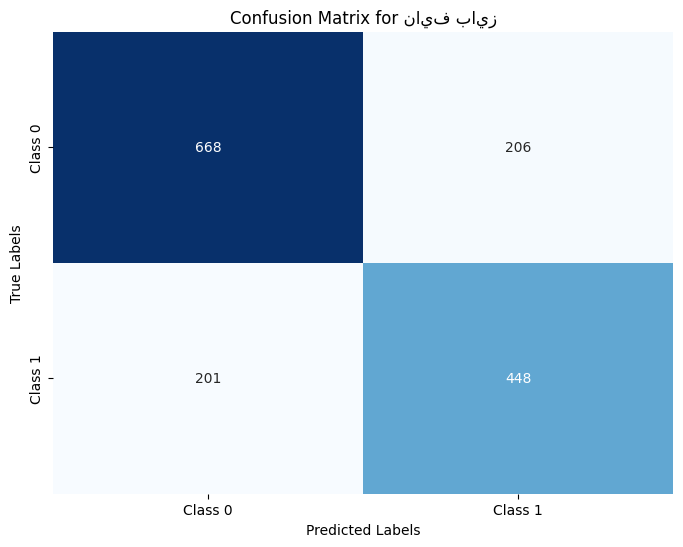

Logistic Regression:  0.7235718975705844
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       874
           1       0.67      0.69      0.68       649

    accuracy                           0.72      1523
   macro avg       0.72      0.72      0.72      1523
weighted avg       0.72      0.72      0.72      1523



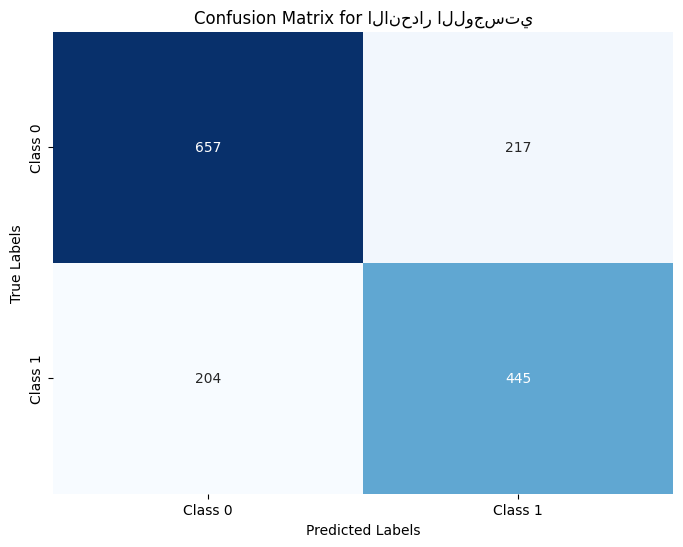

Support Vector Machines :  0.7774130006565988
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       874
           1       0.87      0.56      0.68       649

    accuracy                           0.78      1523
   macro avg       0.81      0.75      0.76      1523
weighted avg       0.80      0.78      0.77      1523



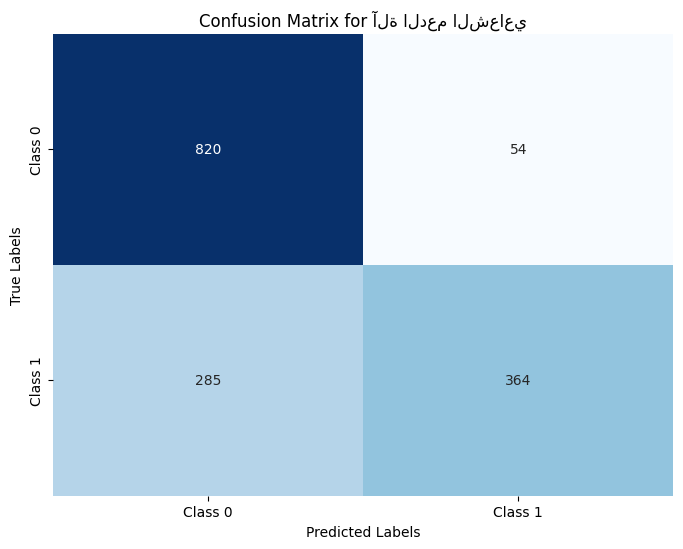

neural networks:  0.7281680892974393
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       874
           1       0.68      0.67      0.68       649

    accuracy                           0.73      1523
   macro avg       0.72      0.72      0.72      1523
weighted avg       0.73      0.73      0.73      1523



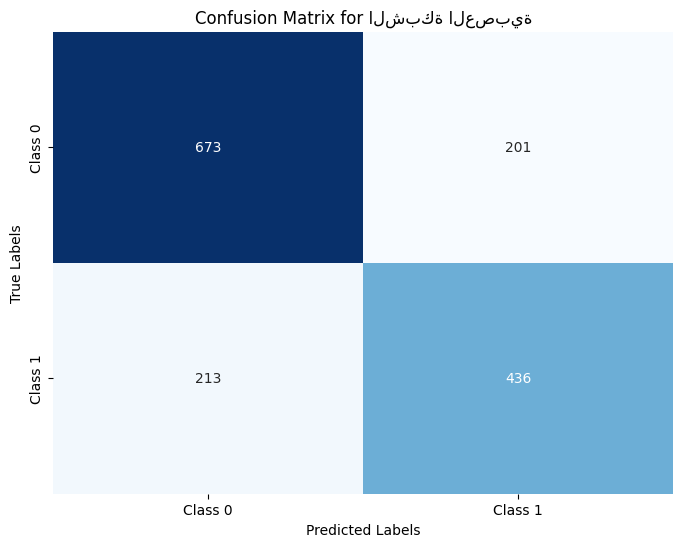

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

nb_pred = nb_model.predict(X_val)
print("Naive Bayes : ", accuracy_score(y_val, nb_pred))
print(classification_report(y_val, nb_pred))
plot_confusion_matrix(y_val, nb_pred, 'نايف بايز')

lr_pred = lr_best_model.predict(X_val)
print("Logistic Regression: ", accuracy_score(y_val, lr_pred))
print(classification_report(y_val, lr_pred))
plot_confusion_matrix(y_val, lr_pred, 'الانحدار اللوجستي')

svm_pred = svm_best_model.predict(X_val)
print("Support Vector Machines : ", accuracy_score(y_val, svm_pred))
print(classification_report(y_val, svm_pred))
plot_confusion_matrix(y_val, svm_pred, 'آلة الدعم الشعاعي')

nn_pred = nn_best_model.predict(X_val)
print("neural networks: ", accuracy_score(y_val, nn_pred))
print(classification_report(y_val, nn_pred))
plot_confusion_matrix(y_val, nn_pred, 'الشبكة العصبية')
